# In this notebook, we will demo how to benchmark a trained model

We will be using [fvcore](https://github.com/facebookresearch/fvcore) package for computing the FLOPS and [pandas](https://pandas.pydata.org/docs/) to display the results nicely.

In [ ]:
# !pip install cellseg-models-pytorch[all]
# !pip install pandas
# !pip install -U fvcore

First we need to run the inference on the test set! Depending on the dataset, you need to decide whether to use the `SlidingWindowInferer` or `ResizeInferer`. Here, we have trained a cellpose model (without any bells and whistles) for 20 epochs on the [Pannuke](https://arxiv.org/abs/2003.10778) folds 2 and 3 and are going to use fold 1 as the test set. Pannuke dataset contains 256x256 patches so we are going to use the `ResizeInferer`.

In [2]:
from cellseg_models_pytorch.models import get_model
from cellseg_models_pytorch.inference import SlidingWindowInferer, ResizeInferer

# the pannuke classes
type_classes = {
    "background": 0,
    "neoplastic": 1,
    "inflammatory": 2,
    "connective": 3,
    "dead": 4,
    "epithelial": 5,
}

# Initializee the model and input and ckpt paths
model = get_model("cellpose", type="base", ntypes=len(type_classes))
input_images = "/path/to/pannuke/fold1/images/" # modify this path
ckpt_path = "/path/to/fold23_weights.ckpt" # modify this path

# Initialize the output head args
out_activations={"type": "softmax", "cellpose": None}
out_boundary_weights={"type": False, "cellpose": False}

# Initialize the inferer
inferer = ResizeInferer(
    model=model,
    input_path=input_images,
    checkpoint_path=ckpt_path,
    out_activations=out_activations,
    out_boundary_weights=out_boundary_weights,
    resize=(256, 256), # not actually resizing anything
    instance_postproc="cellpose",
    normalization="minmax", # minmax normalization was used for training
)

In [3]:
# Run the inference
inferer.infer(save_intermediate=True) # save_intermediate needs to be set to True for latency benchmarks.

Running inference: 100%|██████████| 332/332 [02:47<00:00,  1.98batch/s, post-processing]


#### Let's plot a few result segmentation masks before benchmarking

Some of the results look reasonable some maybe less so. This indicates that we should have trained longer and maybe should have used different sampling strategies or other bells and whistles.

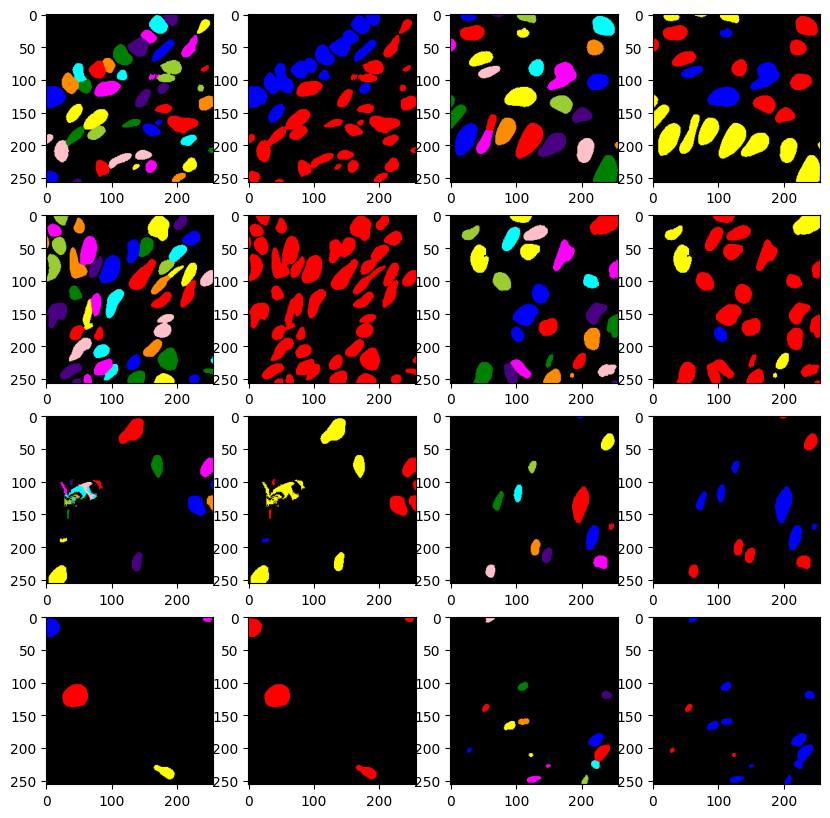

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

samples = list(inferer.out_masks.keys())
randints = list(np.random.randint(low=0, high=len(samples), size=8))
keys = [samples[i] for i in randints]

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
ax = ax.flatten()
ax[0].imshow(label2rgb(inferer.out_masks[keys[0]]["inst"], bg_label=0))
ax[1].imshow(label2rgb(inferer.out_masks[keys[0]]["type"], bg_label=0))
ax[2].imshow(label2rgb(inferer.out_masks[keys[1]]["inst"], bg_label=0))
ax[3].imshow(label2rgb(inferer.out_masks[keys[1]]["type"], bg_label=0))
ax[4].imshow(label2rgb(inferer.out_masks[keys[2]]["inst"], bg_label=0))
ax[5].imshow(label2rgb(inferer.out_masks[keys[2]]["type"], bg_label=0))
ax[6].imshow(label2rgb(inferer.out_masks[keys[3]]["inst"], bg_label=0))
ax[7].imshow(label2rgb(inferer.out_masks[keys[3]]["type"], bg_label=0))
ax[8].imshow(label2rgb(inferer.out_masks[keys[4]]["inst"], bg_label=0))
ax[9].imshow(label2rgb(inferer.out_masks[keys[4]]["type"], bg_label=0))
ax[10].imshow(label2rgb(inferer.out_masks[keys[5]]["inst"], bg_label=0))
ax[11].imshow(label2rgb(inferer.out_masks[keys[5]]["type"], bg_label=0))
ax[12].imshow(label2rgb(inferer.out_masks[keys[6]]["inst"], bg_label=0))
ax[13].imshow(label2rgb(inferer.out_masks[keys[6]]["type"], bg_label=0))
ax[14].imshow(label2rgb(inferer.out_masks[keys[7]]["inst"], bg_label=0))
ax[15].imshow(label2rgb(inferer.out_masks[keys[7]]["type"], bg_label=0))

### Segmentation Performance Benchmarks

Next, we are going to benchmark the segmentation results with the panoptic quality metric (PQ).
We are going to compute the metric per each cell type class. 

In [5]:
from cellseg_models_pytorch.utils.seg_benchmark import SegBenchmarker

in_dir = "/path/to/pannuke/fold1/labels" # modify this path
bm = SegBenchmarker(
    true_path=in_dir,
    inferer=inferer,
    type_classes=type_classes,
)

benchmark_res = bm.run_inst_benchmark(how="multi")

Running epithelial inst benchmark: 100%|██████████| 266/266 [00:08<00:00, 32.88it/s]


### Sneak peak on the metrics result table

Some of the metrics are clamped to -1.0. This means that neither the ground truth labels or the resulting segmentation masks contained the corresponding class. These are filtered out in the next steps.

In [6]:
import pandas as pd

res_df = pd.DataFrame(benchmark_res)
res_df

,pq,sq,dq,name,type
0,0.629760,0.845205,0.745098,Adrenal_gland_fold1_0,neoplastic
1,0.704438,0.858534,0.820513,Adrenal_gland_fold1_1,neoplastic
2,0.531160,0.849855,0.625000,Adrenal_gland_fold1_10,neoplastic
3,0.780535,0.902494,0.864865,Adrenal_gland_fold1_100,neoplastic
4,-1.000000,-1.000000,-1.000000,Adrenal_gland_fold1_101,neoplastic
...,...,...,...,...,...
13275,-1.000000,-1.000000,-1.000000,Uterus_fold1_5,epithelial
13276,-1.000000,-1.000000,-1.000000,Uterus_fold1_6,epithelial
13277,0.000000,0.000000,0.000000,Uterus_fold1_7,epithelial
13278,-1.000000,-1.000000,-1.000000,Uterus_fold1_8,epithelial


Next, we'll compute the mean PQ over the per-class PQs. As you can see, it's not very good.

In [7]:
# This is the mPQ over all per-class PQs.
res_df[res_df[["pq", "dq", "sq"]] >= 0].mean(axis=0)

pq      0.354983
sq      0.550885
dq      0.441920
name         NaN
type         NaN
dtype: float64

The Pannuke dataset contains lot of images that contain only a few cells. The models can easily fail to detect any of these which results in PQ=0. If we also filter out examples with PQ=0 we get a drastic increase.

In [8]:
# If we filter out also the examples that got 
res_df[res_df[["pq", "dq", "sq"]] > 0].mean(axis=0)

pq      0.513649
sq      0.797112
dq      0.639444
name         NaN
type         NaN
dtype: float64

We can also look at the mean PQ per cell-type to get a clearer picture of the hard to detect classes. Turns out that the dead cell class is very hard to detect. Reason for this is that there are very few examples of dead cells in the training set.. All in all, the results are far from being SOTA so there is still a lot of proper training to do to get a matching performance. On the bright side, the model learned a decent mapping with only a handful of training epochs.

In [9]:
res_df.loc[res_df['pq'] >= 0].groupby("type").mean(numeric_only=True)

,pq,sq,dq
type,,,
connective,0.315990,0.543382,0.408232
dead,0.009412,0.081074,0.014467
epithelial,0.370907,0.549539,0.468822
inflammatory,0.306563,0.467061,0.377805
neoplastic,0.468043,0.668050,0.563139


## Latency and throughput Benchmarks

Next we will benchmark the model latency. These models typically have an NN backbone that spits out intermediate outputs that need to be post-processed. Thus, we will benchmark the latencies and throughputs for the post-processing and NN backbone forward pass separately. This benchmarking was done on a laptop with:

- a worn-out NVIDIA GeForce RTX 2080 Mobile (8Gb VRAM)
- Intel i7-9750H 6 x 6 cores @ 2.60GHz (32 GiB RAM)

**NOTE**:
- NN backbone latency = time in seconds for one forward pass of the model
- post-processing latency = time in seconds for one pass of the post-processing function.

In [10]:
from cellseg_models_pytorch.utils.latency_benchmark import LatencyBenchmarker

lat_bm = LatencyBenchmarker(inferer=inferer)

First, let's compute the model forward pass mean latency over 100 samples (in seconds).

We also report the input size and batch size since those have an effect on the result.

In [11]:
model_latency = lat_bm.model_latency(reps=100, input_size=(256, 256), batch_size=8)
pd.DataFrame(model_latency)

100%|██████████| 100/100 [00:07<00:00, 13.85rep/s]


,batch_size,input_shape,mean latency(s),std latency(s)
0,8,"(3, 256, 256)",0.071261,0.000297


Then, let's get the post-processing latencies. This cellpose model's post-processing pipeline contains instance segmentation post-processing and cell type segmentation post-processing.

Note that, the post-processing latencies depend on the number of cells in each image, thus, we are going to compute the latencies over the whole pannuke fold3. We are going to run the post-processing 10 times per image and report the mean for each image.

**NOTE**: This takes a while to finsh.

In [14]:
inst_post_proc_lat = lat_bm.postproc_latency("inst", reps_per_img=10)
inst_post_proc_lat = pd.DataFrame(inst_post_proc_lat)
type_post_proc_lat = lat_bm.postproc_latency("type", reps_per_img=10)
type_post_proc_lat = pd.DataFrame(type_post_proc_lat)

100%|██████████| 2656/2656 [02:35<00:00, 17.10it/s]


### Sneak peak to latency benchmark tables

The Pannuke images are so small (256x256px) that the latencies are small as well. However, for larger images, the post-procesing methods can become a bottleneck. 

Note that the number of cells and number of pixels non-zero pixels are reported as well since they have an effect on the latency.

In [19]:
inst_post_proc_lat

,repetitions,mean latency(s),std latency(s),input_shape,ncells,npixels,name
0,10,0.033668,0.011313,"(256, 256)",30,14036,Adrenal_gland_fold1_0
1,10,0.029491,0.000736,"(256, 256)",22,10700,Adrenal_gland_fold1_1
2,10,0.031859,0.002062,"(256, 256)",26,9238,Adrenal_gland_fold1_10
3,10,0.033126,0.002427,"(256, 256)",21,11581,Adrenal_gland_fold1_100
4,10,0.030292,0.002052,"(256, 256)",5,1773,Adrenal_gland_fold1_101
...,...,...,...,...,...,...,...
2651,10,0.024961,0.000670,"(256, 256)",8,4200,Uterus_fold1_5
2652,10,0.033751,0.004854,"(256, 256)",28,22435,Uterus_fold1_6
2653,10,0.029906,0.002054,"(256, 256)",5,1108,Uterus_fold1_7
2654,10,0.032594,0.000991,"(256, 256)",31,9882,Uterus_fold1_8


In [20]:
type_post_proc_lat

,repetitions,mean latency(s),std latency(s),img_shape,ncells,npixels,name
0,10,0.005883,0.001243,"(256, 256)",30,14036,Adrenal_gland_fold1_0
1,10,0.006105,0.001933,"(256, 256)",22,10700,Adrenal_gland_fold1_1
2,10,0.004274,0.000409,"(256, 256)",26,9238,Adrenal_gland_fold1_10
3,10,0.003436,0.000439,"(256, 256)",21,11581,Adrenal_gland_fold1_100
4,10,0.003133,0.000218,"(256, 256)",5,1773,Adrenal_gland_fold1_101
...,...,...,...,...,...,...,...
2651,10,0.005212,0.000586,"(256, 256)",8,4200,Uterus_fold1_5
2652,10,0.007198,0.000778,"(256, 256)",28,22435,Uterus_fold1_6
2653,10,0.005758,0.000429,"(256, 256)",5,1108,Uterus_fold1_7
2654,10,0.006258,0.000985,"(256, 256)",31,9882,Uterus_fold1_8


Let's compute the means for both post-processing methods.

In [22]:
type_post_proc_lat.mean(axis=0, numeric_only=True)

repetitions          10.000000
mean latency(s)       0.004334
std latency(s)        0.000701
ncells               22.921687
npixels            9801.875753
dtype: float64

In [24]:
inst_post_proc_lat.mean(axis=0, numeric_only=True)

repetitions          10.000000
mean latency(s)       0.031553
std latency(s)        0.003438
ncells               22.921687
npixels            9801.875753
dtype: float64

### Throughputs

In practice, the model (NN-backbone + post-processing + intermediate data-wrangilng) throughput is a lot more valuable metric than the latencies since it directly tells how scalable the model is. The throughput is important information especially when segmenting a large number of huge gigapixel images like WSIs.

Next, we will compute the whole model inference + post-processing throughput (img/s).

In [26]:
# this returns the throughput of the inferer.infer() method
throughputs = pd.DataFrame(lat_bm.inference_postproc_latency(reps=1))
throughputs

Running inference: 100%|██████████| 332/332 [02:45<00:00,  2.01batch/s, post-processing]


,n_images,repetitions,total mean latency(s),total std latency(s),mean throughput (img/s),std throughput (img/s))
0,2656,1,165.549179,0.0,0.06233,0.0


It took 2 min 45 sec to run the inference pipeline on this laptop on the Pannuke fold3 containing 2656 (256x256) images. This averages to ~0.06 seconds per image. Note that the std is zero since we had run the whole pipeline only once.

### Compute the model parameters and FLOPS

Finally we will compute the NN backbone FLOPS and the number of learnable params with the [fvcore](https://github.com/facebookresearch/fvcore) library. FLOPS are typically reported in research papers, so why not here as well.

In [29]:
from fvcore.nn import FlopCountAnalysis, ActivationCountAnalysis, flop_count_table
import torch

inp = torch.rand([8, 3, 256, 256]).to("cuda")
flops = FlopCountAnalysis(model, inp)

print(flop_count_table(flops))

| module                                                                         | #parameters or shape   | #flops     |
|:-------------------------------------------------------------------------------|:-----------------------|:-----------|
| model                                                                          | 15.119M                | 0.153T     |
|  encoder.model                                                                 |  8.543M                |  34.47G    |
|   encoder.model.conv1                                                          |   9.408K               |   1.233G   |
|    encoder.model.conv1.weight                                                  |    (64, 3, 7, 7)       |            |
|   encoder.model.bn1                                                            |   0.128K               |   16.777M  |
|    encoder.model.bn1.weight                                                    |    (64,)               |            |
|    encoder.model.bn1.bias     

- The model has 15.9M parameters (Very small)
- One forward pass takes 153 GFlops (not too much)

Overall, this cellpose model is very lightweight. Adding some width and depth to the layers would probably do some magic (in terms of the segmentation results) without bloating the model too much. So, in conclusion, there is a lot of room for improvement, both on the architecture and training side of the model. However, lightweight models can be more suitable for a large number of huge images if you have limited time and compute resources. 

This concludes this notebook, thanks!